# 1.0 安裝套件 & 環境

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pandas.tseries.offsets import MonthEnd
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import xgboost #機器學習套件

plt.style.use('ggplot')
plt.rcParams.update({
    'font.weight': 'bold',
    'text.color': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k'})
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.0 股票因子計算


## 2.1 價量因子

In [ ]:
# 讀入台股價量資料
df_price = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')

df_price.head()

,證券名稱,資料日,市場別,開盤價,最高價,最低價,收盤價,成交量(千股),成交金額(元),成交筆數,周轉率,流通在外股數(千股),個股市值(元),市值比重,成交金額比重,現金股利率(TEJ),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ)
0,1101台泥,2018-01-02,TWSE,36.45,36.60,36.05,20.444681,13698.0,499370945.0,3932.0,0.3226,4246509.0,1.552099e+11,0.485348,0.522,3.45,20.26,1.38,1.63
1,1102亞泥,2018-01-02,TWSE,28.30,28.40,28.05,19.734614,6669.0,187956859.0,2492.0,0.1984,3361447.0,9.479281e+10,0.296421,0.196,3.19,19.28,0.75,1.52
2,1103嘉泥,2018-01-02,TWSE,13.35,13.45,13.15,10.054507,1007.0,13406478.0,346.0,0.1300,774781.0,1.042080e+10,0.032586,0.014,1.49,173.87,0.61,4.01
3,1104環泥,2018-01-02,TWSE,23.00,23.05,22.90,16.405601,344.0,7919719.0,184.0,0.0526,653609.0,1.503301e+10,0.047009,0.008,5.07,10.07,0.93,3.31
4,1108幸福,2018-01-02,TWSE,8.35,8.40,8.35,7.062476,95.0,799475.0,51.0,0.0235,404738.0,3.399799e+09,0.010631,0.001,7.14,52.41,0.75,0.92


In [ ]:
df_price.columns

Index(['證券名稱', '資料日', '市場別', '開盤價', '最高價', '最低價', '收盤價', '成交量(千股)', '成交金額(元)',
       '成交筆數', '周轉率', '流通在外股數(千股)', '個股市值(元)', '市值比重', '成交金額比重', '現金股利率(TEJ)',
       '本益比(TEJ)', '股價淨值比(TEJ)', '股價營收比(TEJ)'],
      dtype='object')

In [ ]:
df_mmt = df_price[['證券名稱','資料日','收盤價','個股市值(元)','本益比(TEJ)']]


# 歷史報酬因子
# groupby:依照證券代碼分群 ； apply:套用計算函式 ； reset_index:groupby運算後回復原本排序
df_mmt['10日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(10) - 1).reset_index(level=0,drop=True)
df_mmt['20日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(20) - 1).reset_index(level=0,drop=True)
df_mmt['60日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(60) - 1).reset_index(level=0,drop=True)
df_mmt['120日歷史報酬'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(120) - 1).reset_index(level=0,drop=True)

# 技術指標因子
df_mmt['每日漲跌幅'] = df_mmt.groupby('證券名稱').apply(lambda x:x['收盤價'] - x['收盤價'].shift(1)).reset_index(level=0,drop=True)
df_mmt['每日漲幅'] = df_mmt['每日漲跌幅'].apply(lambda x:x if x > 0 else 0)
df_mmt['每日跌幅'] = df_mmt['每日漲跌幅'].apply(lambda x:x if x < 0 else 0)

df_mmt['10日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(10).mean().reset_index(level=0,drop=True)
df_mmt['10日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(10).mean().reset_index(level=0,drop=True)
df_mmt['10日RS'] = df_mmt['10日平均漲幅'] / abs(df_mmt['10日平均跌幅'])
df_mmt['10日RSI'] = (df_mmt['10日RS'] / (1 + df_mmt['10日RS'])) *100

df_mmt['20日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(20).mean().reset_index(level=0,drop=True)
df_mmt['20日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(20).mean().reset_index(level=0,drop=True)
df_mmt['20日RS'] = df_mmt['20日平均漲幅'] / abs(df_mmt['20日平均跌幅'])
df_mmt['20日RSI'] = (df_mmt['20日RS'] / (1 + df_mmt['20日RS'])) *100

df_mmt['60日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(60).mean().reset_index(level=0,drop=True)
df_mmt['60日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(60).mean().reset_index(level=0,drop=True)
df_mmt['60日RS'] = df_mmt['60日平均漲幅'] / abs(df_mmt['60日平均跌幅'])
df_mmt['60日RSI'] = (df_mmt['60日RS'] / (1 + df_mmt['60日RS'])) *100

df_mmt['120日平均漲幅'] = df_mmt.groupby('證券名稱')['每日漲幅'].rolling(120).mean().reset_index(level=0,drop=True)
df_mmt['120日平均跌幅'] = df_mmt.groupby('證券名稱')['每日跌幅'].rolling(120).mean().reset_index(level=0,drop=True)
df_mmt['120日RS'] = df_mmt['120日平均漲幅'] / abs(df_mmt['120日平均跌幅'])
df_mmt['120日RSI'] = (df_mmt['120日RS'] / (1 + df_mmt['120日RS'])) *100

df_mmt['10日平均本益比'] = df_mmt.groupby('證券名稱')['本益比(TEJ)'].rolling(10).mean().reset_index(level=0, drop=True)
df_mmt['20日平均本益比'] = df_mmt.groupby('證券名稱')['本益比(TEJ)'].rolling(20).mean().reset_index(level=0, drop=True)
df_mmt['60日平均本益比'] = df_mmt.groupby('證券名稱')['本益比(TEJ)'].rolling(60).mean().reset_index(level=0, drop=True)
df_mmt['120日平均本益比'] = df_mmt.groupby('證券名稱')['本益比(TEJ)'].rolling(120).mean().reset_index(level=0, drop=True)

# 驗證計算結果
df_mmt[df_mmt['證券名稱'] == '1103嘉泥'].tail()

,證券名稱,資料日,收盤價,個股市值(元),本益比(TEJ),10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,每日漲跌幅,...,60日RS,60日RSI,120日平均漲幅,120日平均跌幅,120日RS,120日RSI,10日平均本益比,20日平均本益比,60日平均本益比,120日平均本益比
2329923,1103嘉泥,2023-11-24,18.95,1.497519e+10,49.3053,0.035519,0.058659,0.021563,-0.043348,-0.10,...,1.114286,52.702703,0.086552,-0.093707,0.923640,48.015222,48.91497,48.056350,57.387958,69.035901
2331619,1103嘉泥,2023-11-27,18.95,1.497519e+10,49.3053,0.032698,0.058659,0.016086,-0.043348,0.00,...,1.085714,52.054795,0.086552,-0.093707,0.923640,48.015222,49.07109,48.192950,56.981862,68.785162
2333315,1103嘉泥,2023-11-28,19.05,1.505421e+10,49.5654,0.043836,0.070225,0.013298,-0.040639,0.10,...,1.071429,51.724138,0.086982,-0.093707,0.928236,48.139140,49.27923,48.355565,56.570225,68.534977
2335011,1103嘉泥,2023-11-29,19.10,1.509373e+10,49.6955,0.026882,0.067039,0.005263,-0.042779,0.05,...,1.028571,50.704225,0.086594,-0.093707,0.924090,48.027376,49.40932,48.511675,56.147590,68.282648
2336708,1103嘉泥,2023-11-30,19.35,1.529129e+10,50.3460,0.032000,0.077994,0.023810,-0.037244,0.25,...,1.132353,53.103448,0.087469,-0.093707,0.933433,48.278520,49.56543,48.693805,55.742380,68.030900


## 2.2 籌碼因子

In [ ]:
# 讀入台股籌碼資料
df_chip = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//籌碼資料.feather')
df_chip.head()

,證券名稱,資料日,市場別,外資買進張數,外資賣出張數,外資買賣超張數,外資買進金額(元),外資賣出金額(元),外資買賣超金額(元),外資持股率,...,融券餘額(元),資券比,資券互抵,資券互抵(元),借券賣出,借券賣出(元),借券餘額,借券餘額(元),當沖成交股數(千股),當沖買賣占比
0,1101台泥,2018-01-02,TWSE,3969.0,3563.0,406.0,145067.0,130228.0,14839.0,32.54,...,18408.87,6.66,0.0,0.0,19.0,692.61,15016.0,547381.25,558.0,4.07
1,1102亞泥,2018-01-02,TWSE,1091.0,73.0,1019.0,30766.0,2059.0,28736.0,19.42,...,1916.25,1.82,0.0,0.0,1.0,28.18,7239.0,203995.74,329.0,4.93
2,1103嘉泥,2018-01-02,TWSE,1.0,114.0,-113.0,13.0,1533.0,-1520.0,3.08,...,465.71,0.95,0.0,0.0,0.0,0.00,1580.0,21023.64,53.0,5.26
3,1104環泥,2018-01-02,TWSE,132.0,112.0,20.0,3036.0,2576.0,460.0,17.97,...,68.97,0.20,0.0,0.0,0.0,0.00,841.0,19333.58,0.0,0.00
4,1108幸福,2018-01-02,TWSE,0.0,0.0,0.0,0.0,0.0,0.0,2.35,...,0.00,0.00,0.0,0.0,0.0,0.00,667.0,5593.13,0.0,0.00


In [ ]:
df_chip.columns

Index(['證券名稱', '資料日', '市場別', '外資買進張數', '外資賣出張數', '外資買賣超張數', '外資買進金額(元)',
       '外資賣出金額(元)', '外資買賣超金額(元)', '外資持股率', '投信買進張數', '投信賣出張數', '投信買賣超張數',
       '投信買進金額(元)', '投信賣出金額(元)', '投信買賣超金額(元)', '投信持股率', '自營商買進張數(自行)',
       '自營商賣出張數(自行)', '自營買賣超張數(自行)', '自營商買進金額(自行)', '自營商賣出金額(自行)',
       '自營買賣超金額(自行)', '自營商買進張數(避險)', '自營商賣出張數(避險)', '自營買賣超張數(避險)',
       '自營商買進金額(避險)', '自營商賣出金額(避險)', '自營買賣超金額(避險)', '自營商持股率', '合計買進張數',
       '合計賣出張數', '合計買賣超張數', '合計買進金額(元)', '合計賣出金額(元)', '合計買賣超金額(元)', '融資買進',
       '融資賣出', '融資餘額', '融資餘額(元)', '融券買進', '融券賣出', '融券餘額', '融券餘額(元)', '資券比',
       '資券互抵', '資券互抵(元)', '借券賣出', '借券賣出(元)', '借券餘額', '借券餘額(元)', '當沖成交股數(千股)',
       '當沖買賣占比'],
      dtype='object')

In [ ]:
df_chip['三大法人買賣超金額'] = df_chip['外資買賣超金額(元)'] + df_chip['投信買賣超金額(元)'] + df_chip['自營買賣超金額(自行)'] + df_chip['自營買賣超金額(避險)']
df_chip['券資比'] = np.where(df_chip['資券比'] != 0, 1 / df_chip['資券比'], np.nan)
df_chip['券資比'] = df_chip['券資比'] * 100

df_chip[['證券名稱', '資料日','外資買賣超金額(元)','投信買賣超金額(元)','自營買賣超金額(自行)','自營買賣超金額(避險)','三大法人買賣超金額','券資比']].head()

,證券名稱,資料日,外資買賣超金額(元),投信買賣超金額(元),自營買賣超金額(自行),自營買賣超金額(避險),三大法人買賣超金額,券資比
0,1101台泥,2018-01-02,14839.0,26755.0,14035.0,-2010.0,53619.0,15.015015
1,1102亞泥,2018-01-02,28736.0,649.0,761.0,0.0,30146.0,54.945055
2,1103嘉泥,2018-01-02,-1520.0,0.0,0.0,0.0,-1520.0,105.263158
3,1104環泥,2018-01-02,460.0,0.0,0.0,0.0,460.0,500.000000
4,1108幸福,2018-01-02,0.0,0.0,0.0,0.0,0.0,NaN


## 2.3 月營收因子

In [ ]:
# 讀入台股月營收資料
df_sales = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//月營收資料.feather')
df_sales.drop_duplicates(subset=['證券名稱','營收發布日'],inplace=True)
df_sales = df_sales.reset_index(drop=True)
df_sales.head()

,證券名稱,年月,營收發布日,單月營收(千元),去年單月營收(千元),單月營收成長率％,單月營收與上月比％,累計營收(千元),去年累計營收(千元),累計營收成長率％,...,與歷史最高單月營收比%,歷史最低單月營收(千元),與歷史最低單月營收比%,近12月累計營收(千元),去年近12月累計營收(千元),近12月累計營收成長率％,近 3月累計營收(千元),去年近 3月累計營收(千元),近3月累計營收成長率％,近3月累計營收與上月比％
0,1101台泥,2018-01-01,2018-02-12,9617393.0,6131670.0,56.85,-12.47,9617393.0,6131670.0,56.85,...,-16.82,3632053.0,164.79,101799228.0,89127748.0,14.22,30591439.0,24417239.0,25.29,4.19
1,1102亞泥,2018-01-01,2018-02-09,6769986.0,4162130.0,62.66,-4.25,6769986.0,4162130.0,62.66,...,-10.78,2552357.0,165.24,67507039.0,60068678.0,12.38,20479859.0,15517862.0,31.98,4.76
2,1103嘉泥,2018-01-01,2018-02-12,172094.0,232657.0,-26.03,-4.98,172094.0,232657.0,-26.03,...,-83.36,132940.0,29.45,2035321.0,3175398.0,-35.90,535074.0,969076.0,-44.79,0.89
3,1104環泥,2018-01-01,2018-02-09,460482.0,363865.0,26.55,15.18,460482.0,363865.0,26.55,...,-16.62,293590.0,56.85,4501993.0,4612753.0,-2.40,1241843.0,1238222.0,0.29,11.12
4,1108幸福,2018-01-01,2018-02-09,320340.0,316773.0,1.13,9.87,320340.0,316773.0,1.13,...,-38.26,232100.0,38.02,3406838.0,4219568.0,-19.26,870824.0,1010162.0,-13.79,7.47


In [ ]:
df_sales.columns

Index(['證券名稱', '年月', '營收發布日', '單月營收(千元)', '去年單月營收(千元)', '單月營收成長率％',
       '單月營收與上月比％', '累計營收(千元)', '去年累計營收(千元)', '累計營收成長率％', '歷史最高單月營收(千元)',
       '與歷史最高單月營收比%', '歷史最低單月營收(千元)', '與歷史最低單月營收比%', '近12月累計營收(千元)',
       '去年近12月累計營收(千元)', '近12月累計營收成長率％', '近 3月累計營收(千元)', '去年近 3月累計營收(千元)',
       '近3月累計營收成長率％', '近3月累計營收與上月比％'],
      dtype='object')

In [ ]:
df_sales['月營收_MoM'] = df_sales.groupby('證券名稱').apply(lambda x: (x['單月營收(千元)'] - x['單月營收(千元)'].shift(1)) / x['單月營收(千元)'].shift(1)).reset_index(level=0,drop=True)
df_sales['月營收_YoY'] = df_sales.groupby('證券名稱').apply(lambda x: (x['單月營收(千元)'] - x['單月營收(千元)'].shift(12)) / x['單月營收(千元)'].shift(12)).reset_index(level=0,drop=True)

# 計算近3月營收YoY
df_sales['近3月營收'] = df_sales.groupby('證券名稱')['單月營收(千元)'].rolling(3).sum().reset_index(level=0,drop=True)
df_sales['近3月營收_YoY'] = df_sales.groupby('證券名稱').apply(lambda x: (x['近3月營收'] - x['近3月營收'].shift(12)) / x['近3月營收'].shift(12)).reset_index(level=0,drop=True)
df_sales['QoQ'] = df_sales.groupby('證券名稱').apply(lambda x: (x['近3月營收'] - x['近3月營收'].shift(1)) / x['近3月營收'].shift(1)*100).reset_index(level=0,drop=True)

# 驗證計算結果
df_sales[df_sales['證券名稱'] == '1101台泥'][['證券名稱', '營收發布日', '單月營收(千元)', '月營收_MoM', '月營收_YoY', '近3月營收_YoY', '近3月累計營收成長率％','QoQ']].tail()

,證券名稱,營收發布日,單月營收(千元),月營收_MoM,月營收_YoY,近3月營收_YoY,近3月累計營收成長率％,QoQ
120833,1101台泥,2023-07-10,8816109.0,-0.081281,-0.036068,0.091797,9.18,-9.578001
122835,1101台泥,2023-08-10,8953462.0,0.015580,-0.113735,0.014210,1.42,-0.533059
124844,1101台泥,2023-09-11,9379408.0,0.047573,-0.122588,-0.093169,-9.32,-0.791806
126856,1101台泥,2023-10-11,8735157.0,-0.068688,-0.160477,-0.132358,-13.24,-0.298177
128873,1101台泥,2023-11-10,9371746.0,0.072877,-0.175610,-0.153300,-15.33,1.545307


## 2.4 財報因子

In [ ]:
# 讀入台股季財報資料
df_fin = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//季財報資料.feather')
df_fin.drop_duplicates(subset=['證券名稱','編表日'],inplace=True)
df_fin = df_fin.reset_index(drop=True)
df_fin.head()

,證券名稱,年/月,期間別,序號,季別,合併(Y/N),幣別,編表日,產業別,現金及約當現金,...,固定資產週轉率,期末收帳天數,期末付帳天數,期末售貨天數,每股淨值,每股營業收入,每股營業利益,每股稅前淨利,每股稅後淨利,每人營收
0,1101台泥,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,24192833.0,...,0.19,227.60,37.62,45.58,35.21,5.69,1.10,1.09,0.67,2584.35
1,1102亞泥,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,10204539.0,...,0.29,143.69,47.32,47.76,38.54,5.31,0.80,0.91,0.72,2991.07
2,1103嘉泥,2018-03-01,Q,001,1,Y,TWD,2018-05-14,F,1498081.0,...,0.15,35.59,39.75,155.75,23.51,0.61,-0.07,0.25,0.21,2076.02
3,1104環泥,2018-03-01,Q,001,1,Y,TWD,2018-05-14,F,228393.0,...,0.18,75.41,42.91,26.81,26.89,1.78,0.08,0.02,0.00,NaN
4,1108幸福,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,199622.0,...,0.51,67.40,42.44,411.16,10.84,2.06,-0.09,-0.08,-0.02,1682.23


In [ ]:
df_fin.columns

Index(['證券名稱', '年/月', '期間別', '序號', '季別', '合併(Y/N)', '幣別', '編表日', '產業別',
       '現金及約當現金',
       ...
       '固定資產週轉率', '期末收帳天數', '期末付帳天數', '期末售貨天數', '每股淨值', '每股營業收入', '每股營業利益',
       '每股稅前淨利', '每股稅後淨利', '每人營收'],
      dtype='object', length=106)

In [ ]:
# 計算營利率YoY
df_fin['毛利率'] = df_fin['營業利益'] / df_fin['營業收入']
df_fin['毛利率_YoY'] = df_fin.groupby('證券名稱').apply(lambda x: (x['毛利率'] - x['毛利率'].shift(4)) / x['毛利率'].shift(4)).reset_index(level=0,drop=True)

# 計算每股稅後淨利_YoY
df_fin['每股稅後淨利_YoY'] = df_fin.groupby('證券名稱').apply(lambda x: (x['每股稅後淨利'] - x['每股稅後淨利'].shift(4)) / x['每股稅後淨利'].shift(4)).reset_index(level=0,drop=True)

# 驗證計算結果
df_fin[df_fin['證券名稱'] == '1101台泥'][['證券名稱', '編表日', '毛利率', '毛利率_YoY', '每股稅後淨利', '每股稅後淨利_YoY']].head()

,證券名稱,編表日,毛利率,毛利率_YoY,每股稅後淨利,每股稅後淨利_YoY
0,1101台泥,2018-05-15,0.192343,NaN,0.67,NaN
1558,1101台泥,2018-08-10,0.269468,NaN,1.82,NaN
3123,1101台泥,2018-11-13,0.228461,NaN,1.26,NaN
4695,1101台泥,2019-03-23,0.206216,NaN,1.10,NaN
6274,1101台泥,2019-05-10,0.198489,0.031958,0.83,0.238806


# 3.0 合併各類因子資料





In [ ]:
####################
# 根據前一部份計算整理，列出想要放入模型的因子
# 需保留'收盤價'欄位，以計算個股下期報酬，供模型訓練
####################

df_mmt_s = df_mmt[['證券名稱', '資料日' ,'收盤價','個股市值(元)','10日歷史報酬','20日歷史報酬','60日歷史報酬','120日歷史報酬','10日RSI','20日RSI','60日RSI','120日RSI','10日平均本益比','20日平均本益比','60日平均本益比','120日平均本益比']]
df_chip_s = df_chip[['證券名稱', '資料日','三大法人買賣超金額','券資比']]
df_sales_s = df_sales[['證券名稱', '營收發布日', '月營收_MoM','月營收_YoY','QoQ']]
df_fin_s = df_fin[['證券名稱', '編表日','毛利率_YoY','每股稅後淨利_YoY']]

In [ ]:
# 將價量以外因子(籌碼、月營收、財報因子)，mapping至日頻率
df_chip_s['資料日'] = pd.to_datetime(df_chip_s['資料日'])
df_chip_s.set_index('資料日', inplace=True)
df_chip_s = df_chip_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_chip_s = df_chip_s.sort_values(by=['證券名稱','資料日']).reset_index()

df_sales_s['營收發布日'] = pd.to_datetime(df_sales_s['營收發布日'])
df_sales_s.set_index('營收發布日', inplace=True)
df_sales_s = df_sales_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_sales_s = df_sales_s.sort_values(by=['證券名稱','營收發布日']).reset_index()

df_fin_s['編表日'] = pd.to_datetime(df_fin_s['編表日'])
df_fin_s.set_index('編表日', inplace=True)
df_fin_s = df_fin_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_fin_s = df_fin_s.sort_values(by=['證券名稱','編表日']).reset_index()

In [ ]:
# 以價量資料(台股交易日)為基準，合併不同頻率之資料
df_all_factor = df_mmt_s.copy()

# merge: 合併兩個dataframe，on=合併基準欄位，how=以哪個dataframe為準)
df_all_factor = pd.merge(df_all_factor, df_chip_s, on=['證券名稱', '資料日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_sales_s, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '營收發布日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_fin_s, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '編表日'], how='left')
df_all_factor.drop(columns=['營收發布日','編表日'],inplace=True)

df_all_factor

,證券名稱,資料日,收盤價,個股市值(元),10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,...,20日平均本益比,60日平均本益比,120日平均本益比,三大法人買賣超金額,券資比,月營收_MoM,月營收_YoY,QoQ,毛利率_YoY,每股稅後淨利_YoY
0,1101台泥,2018-01-02,20.444681,1.552099e+11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,53619.0,15.015015,NaN,NaN,NaN,NaN,NaN
1,1102亞泥,2018-01-02,19.734614,9.479281e+10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30146.0,54.945055,NaN,NaN,NaN,NaN,NaN
2,1103嘉泥,2018-01-02,10.054507,1.042080e+10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1520.0,105.263158,NaN,NaN,NaN,NaN,NaN
3,1104環泥,2018-01-02,16.405601,1.503301e+10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,460.0,500.000000,NaN,NaN,NaN,NaN,NaN
4,1108幸福,2018-01-02,7.062476,3.399799e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338398,9951皇田,2023-11-30,78.000000,5.842200e+09,0.001284,0.056911,0.052632,0.123263,51.162791,67.213115,...,11.940440,12.326452,12.887042,1950.0,666.666667,NaN,NaN,NaN,NaN,NaN
2338399,9955佳龍,2023-11-30,24.900000,2.569885e+09,0.044025,-0.013861,0.101770,-0.034884,66.153846,47.154472,...,NaN,NaN,NaN,-647.0,7.251632,NaN,NaN,NaN,NaN,NaN
2338400,9958世紀鋼,2023-11-30,166.000000,3.917132e+10,-0.023529,0.189964,0.044025,0.480255,43.750000,68.531469,...,151.328505,480.246357,733.185593,53547.0,17.271157,NaN,NaN,NaN,NaN,NaN
2338401,9960邁達康,2023-11-30,26.950000,9.053180e+08,-0.005535,0.038536,0.009363,-0.053666,41.176471,68.518519,...,8.018575,7.669935,7.617833,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 把inf(無限大)填補成缺失值，以利後續一併刪除
df_all_factor.replace([np.inf, -np.inf], np.NaN, inplace=True)

# 刪除含有缺失值之資料行 (若缺失值過多，這步驟會刪掉很多資料，導致後續資料筆數太少，務必在因子計算時先行處理)
df_all_factor.dropna(inplace=True)
df_all_factor = df_all_factor.sort_values(by=['證券名稱','資料日']).reset_index(level=0,drop=True)
df_all_factor = df_all_factor[df_all_factor['個股市值(元)'] <= 2e11]

df_all_factor

,證券名稱,資料日,收盤價,個股市值(元),10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,...,20日平均本益比,60日平均本益比,120日平均本益比,三大法人買賣超金額,券資比,月營收_MoM,月營收_YoY,QoQ,毛利率_YoY,每股稅後淨利_YoY
205,1101台泥,2020-03-18,26.518680,1.967623e+11,-0.159860,-0.163763,-0.148936,-0.102244,7.975460,16.587678,...,9.919190,10.175747,10.110440,-510588.0,22.026432,-0.333431,-0.016611,-21.179353,0.152093,0.023810
206,1101台泥,2020-03-19,24.750768,1.836448e+11,-0.224018,-0.225806,-0.210341,-0.149367,1.980198,11.111111,...,9.802430,10.140203,10.095757,-115349.0,15.797788,-0.333431,-0.016611,-21.179353,0.152093,0.023810
208,1101台泥,2020-03-23,26.592343,1.973089e+11,-0.137395,-0.165318,-0.159488,-0.092965,27.626459,28.267477,...,9.643375,10.089767,10.076772,-190535.0,9.900990,-0.333431,-0.016611,-21.179353,0.275254,0.090909
1069,1102亞泥,2019-05-15,29.399247,1.374832e+11,-0.020359,-0.020359,0.076316,0.237519,36.065574,42.975207,...,12.872655,12.433978,11.729038,-48753.0,40.650407,0.013925,0.173414,2.728507,0.280497,0.569444
1070,1102亞泥,2019-05-16,30.657161,1.433657e+11,0.014269,0.025240,0.122368,0.265579,56.666667,56.862745,...,12.888970,12.458062,11.741148,295138.0,14.577259,0.013925,0.173414,2.728507,0.280497,0.569444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781243,9962有益,2023-11-07,17.700000,1.596899e+09,0.029070,0.032070,0.020173,-0.106061,77.777778,66.666667,...,8.363650,7.641015,7.810487,372.0,1250.000000,-0.168997,-0.235536,1.787783,-0.501382,-0.528571
781244,9962有益,2023-11-08,17.500000,1.578855e+09,0.008646,0.017442,0.005747,-0.122807,57.894737,58.333333,...,8.370930,7.662878,7.812143,193.0,1250.000000,-0.168997,-0.235536,1.787783,-0.501382,-0.528571
781245,9962有益,2023-11-09,17.450000,1.574344e+09,0.008671,0.008671,0.032544,-0.123116,57.894737,54.285714,...,8.374565,7.687775,7.813771,-925.0,1250.000000,-0.168997,-0.235536,1.787783,-0.501382,-0.528571
781246,9962有益,2023-11-10,17.400000,1.569833e+09,0.005780,0.008696,0.014577,-0.125628,55.000000,54.285714,...,8.378205,7.710548,7.815197,-400.0,1250.000000,-0.168997,-0.235536,1.787783,-0.501382,-0.528571


# 4.0 XGBoost選股模型

- XGBoost模型架構
  - 官方文檔 : https://xgboost.readthedocs.io/en/stable/python/
  - https://ithelp.ithome.com.tw/articles/10273094
  - https://medium.com/@pahome.chen/xgboost%E5%85%A5%E9%96%80%E7%B6%93%E9%A9%97%E5%88%86%E4%BA%AB-e06931b835f5



In [ ]:
# 特徵集合(因子集合)
feature_list = df_all_factor.columns.drop(['證券名稱','資料日','收盤價'])

# 取每月第一個交易日的資料
df_feature = df_all_factor.copy()
df_feature['年月'] = df_feature['資料日'].dt.strftime('%Y-%m')
reb_date_all = df_feature[['年月','資料日']].sort_values(by='資料日').drop_duplicates(subset=['年月'], keep = 'first').reset_index(drop=True)
df_feature_m = df_feature[df_feature['資料日'].isin(reb_date_all['資料日'])].copy().reset_index(drop=True)

In [ ]:
df_feature_m[feature_list]


,個股市值(元),10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,60日RSI,120日RSI,10日平均本益比,20日平均本益比,60日平均本益比,120日平均本益比,三大法人買賣超金額,券資比,月營收_MoM,月營收_YoY,QoQ,毛利率_YoY,每股稅後淨利_YoY
0,1.529458e+11,0.034091,0.093750,0.184896,0.376702,67.441860,71.428571,66.435185,64.293915,13.53582,13.315325,12.789220,11.935366,130814.0,8.237232,0.013925,0.173414,2.728507,0.280497,0.569444
1,1.603410e+11,0.020321,0.057650,0.156364,0.382609,57.983193,64.130435,64.175824,64.765101,12.74512,12.557280,12.923415,12.238914,46890.0,13.368984,0.000113,0.095815,26.455577,0.280497,0.569444
2,1.391639e+11,-0.050979,-0.074904,0.047196,0.216425,19.553204,29.706227,53.539538,58.146682,11.64759,12.152080,12.680502,12.498640,70255.0,12.437811,-0.106601,-0.001777,-3.106297,0.280497,0.569444
3,1.467272e+11,0.024648,0.064634,0.012601,0.223393,63.636364,65.142857,51.014811,58.416030,11.37386,11.232985,11.993750,12.401932,21695.0,28.985507,0.036727,0.112803,-2.546437,0.243762,0.418750
4,1.453826e+11,-0.022599,0.005814,-0.033565,0.113857,22.222222,52.212389,46.648440,54.854254,11.54213,11.674020,11.674510,12.300580,-10077.0,36.496350,-0.078062,0.003215,-5.181238,0.243762,0.418750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36481,1.826960e+09,0.009975,0.049223,0.024212,0.273585,57.142857,65.573770,51.632329,57.441875,8.32069,8.284590,8.372042,8.338973,4678.0,714.285714,0.250776,0.325736,-1.086901,0.104976,0.170732
36482,1.664564e+09,0.013736,-0.088889,-0.091133,0.039819,55.813953,31.250000,42.060086,51.200844,7.65857,7.707050,8.067263,8.379657,-111.0,1000.000000,-0.165630,-0.347273,-7.658910,0.104976,0.170732
36483,1.556299e+09,-0.008621,-0.070081,-0.135338,-0.160779,42.857143,30.303030,37.264151,44.113507,7.02741,7.135705,7.694333,8.130749,2174.0,1666.666667,-0.129752,-0.114571,-2.786575,-0.501382,-0.528571
36484,1.542766e+09,-0.039326,-0.008696,-0.131980,-0.189874,6.250000,47.368421,37.619048,41.779339,7.25882,7.258625,7.347875,7.835743,68.0,1428.571429,0.565305,0.081992,5.334243,-0.501382,-0.528571


In [ ]:
# 因子標準化
def standardize(x):
    return (x- x.mean()) / x.std()

df_feature_m[feature_list] = df_feature_m.groupby('資料日')[feature_list].apply(standardize).reset_index(level=0,drop=True)
df_feature_m.head()

,證券名稱,資料日,收盤價,個股市值(元),10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,...,60日平均本益比,120日平均本益比,三大法人買賣超金額,券資比,月營收_MoM,月營收_YoY,QoQ,毛利率_YoY,每股稅後淨利_YoY,年月
0,1102亞泥,2019-06-03,32.705764,4.781448,0.405084,1.444355,1.294138,1.249543,0.694250,1.871077,...,-0.147045,-0.152357,3.375495,-0.371834,0.032359,0.039696,0.419079,0.053896,0.022732,2019-06
1,1102亞泥,2019-07-01,34.287142,5.020585,-0.292614,0.225061,1.108955,0.979850,-0.408261,0.523050,...,-0.173411,-0.161416,0.533937,-0.430363,-0.176367,-0.022309,1.328233,0.067510,0.036739,2019-07
2,1102亞泥,2019-08-01,31.652411,4.408419,-1.004527,-1.065681,0.005998,0.221867,-1.537436,-1.475255,...,-0.275639,-0.192812,1.193219,-0.396367,-0.069457,-0.068652,-0.285032,0.050435,0.027761,2019-08
3,1102亞泥,2019-09-02,33.372651,5.017689,-0.049742,0.243332,-0.570217,0.411187,0.358363,0.769290,...,-0.290185,-0.219712,0.380082,-0.384405,-0.072349,-0.033913,-0.196877,0.022094,0.070779,2019-09
4,1102亞泥,2019-10-01,33.066831,4.467629,-0.423114,-0.096998,-0.592539,0.242691,-1.240205,0.078178,...,-0.294222,-0.224838,-0.145050,-0.387036,-0.298238,-0.056050,-0.585921,-0.032628,0.052001,2019-10


In [ ]:
df_feature_m

,證券名稱,資料日,收盤價,個股市值(元),10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,...,60日平均本益比,120日平均本益比,三大法人買賣超金額,券資比,月營收_MoM,月營收_YoY,QoQ,毛利率_YoY,每股稅後淨利_YoY,年月
0,1102亞泥,2019-06-03,32.705764,4.781448,0.405084,1.444355,1.294138,1.249543,0.694250,1.871077,...,-0.147045,-0.152357,3.375495,-0.371834,0.032359,0.039696,0.419079,0.053896,0.022732,2019-06
1,1102亞泥,2019-07-01,34.287142,5.020585,-0.292614,0.225061,1.108955,0.979850,-0.408261,0.523050,...,-0.173411,-0.161416,0.533937,-0.430363,-0.176367,-0.022309,1.328233,0.067510,0.036739,2019-07
2,1102亞泥,2019-08-01,31.652411,4.408419,-1.004527,-1.065681,0.005998,0.221867,-1.537436,-1.475255,...,-0.275639,-0.192812,1.193219,-0.396367,-0.069457,-0.068652,-0.285032,0.050435,0.027761,2019-08
3,1102亞泥,2019-09-02,33.372651,5.017689,-0.049742,0.243332,-0.570217,0.411187,0.358363,0.769290,...,-0.290185,-0.219712,0.380082,-0.384405,-0.072349,-0.033913,-0.196877,0.022094,0.070779,2019-09
4,1102亞泥,2019-10-01,33.066831,4.467629,-0.423114,-0.096998,-0.592539,0.242691,-1.240205,0.078178,...,-0.294222,-0.224838,-0.145050,-0.387036,-0.298238,-0.056050,-0.585921,-0.032628,0.052001,2019-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36481,9962有益,2023-07-03,20.250000,-0.580104,-0.183357,-0.136593,-0.476935,-0.192253,0.209895,0.688065,...,-0.415215,-0.466815,-0.034252,0.411013,-0.025148,0.305769,-0.108862,0.030872,0.131976,2023-07
36482,9962有益,2023-08-01,18.450000,-0.608523,0.004504,-0.772406,-0.794951,-0.595814,0.265002,-1.248884,...,-0.313980,-0.405792,0.105791,0.823566,-0.043136,0.035512,0.029041,0.045517,0.128797,2023-08
36483,9962有益,2023-09-01,17.250000,-0.595935,-0.564557,-0.612668,-0.841324,-0.818388,-0.980185,-1.298636,...,-0.274668,-0.345432,0.068712,2.274128,-0.391066,-0.142571,-0.428246,-0.063224,-0.134559,2023-09
36484,9962有益,2023-10-02,17.100000,-0.602158,-0.669002,-0.294459,-0.777929,-0.945888,-2.344113,-0.245765,...,-0.115198,-0.136113,-0.109050,1.464115,2.320002,0.061969,0.401012,-0.073510,-0.138547,2023-10


In [ ]:
# 計算個股下期報酬，作為模型訓練答案
df_feature_m['下期報酬'] = df_feature_m.groupby('證券名稱').apply(lambda x:(x['收盤價'].shift(-1) / x['收盤價'] - 1)*10).reset_index(level=0,drop=True)
df_feature_m.dropna(inplace=True)
df_feature_m[df_feature_m['證券名稱'] == '1220台榮'].tail()

,證券名稱,資料日,收盤價,個股市值(元),10日歷史報酬,20日歷史報酬,60日歷史報酬,120日歷史報酬,10日RSI,20日RSI,...,120日平均本益比,三大法人買賣超金額,券資比,月營收_MoM,月營收_YoY,QoQ,毛利率_YoY,每股稅後淨利_YoY,年月,下期報酬
424,1220台榮,2023-04-06,16.968350,-0.542900,-0.394778,-0.713302,-0.240544,-0.250735,-0.427606,-0.758728,...,0.027827,-0.059563,0.342090,-0.085918,-0.292193,-0.451251,-0.094405,-0.104850,2023-04,-0.668605
425,1220台榮,2023-05-02,15.833839,-0.555600,-0.351647,-0.357050,-0.589087,-0.598883,-1.431654,-0.296232,...,0.313387,-0.102555,1.918750,1.075897,0.078437,-0.144715,-0.047187,-0.087605,2023-05,-0.779242
426,1220台榮,2023-08-01,14.600000,-0.578390,0.006492,-0.297423,-0.739050,-0.796606,0.291510,-0.433588,...,1.900156,0.103675,0.465278,-0.041004,0.037742,0.036032,-0.165249,-0.058802,2023-08,-0.171233
427,1220台榮,2023-09-01,14.350000,-0.564824,-0.284481,-0.007218,-0.412591,-0.901487,-0.346631,0.180996,...,1.790486,0.047263,0.607314,-0.191787,-0.100301,-0.130625,0.169961,0.389223,2023-09,-0.278746
428,1220台榮,2023-10-02,13.950000,-0.574650,-0.152953,-0.495261,-0.419780,-0.902024,-0.526712,-0.869565,...,0.746375,-0.103636,0.312629,0.152696,-0.097361,0.080050,0.172594,0.316667,2023-10,-0.286738


In [ ]:
# 切分訓練期和測試期
train_start_st = '2010-01-01'
test_start_st= '2022-01-01'
test_end_dt = '2023-10-31'
df_train = df_feature_m[df_feature_m['資料日'] >= train_start_st]
df_train = df_train[df_train['資料日'] < test_start_st]
df_test = df_feature_m[df_feature_m['資料日'] >= test_start_st]
df_test = df_test[df_test['資料日'] <= test_end_dt]

##################
# 每期選幾檔股票(可調整)
portfolio_stock_num = 11
##################

# 模型訓練及選股
model = xgboost.XGBRegressor()
model.fit(df_train[feature_list], df_train['下期報酬'])
df_test['模型預測分數'] = model.predict(df_test[feature_list])

# 加入獎懲機制
threshold = 0.84 #最佳值為0.84


# 根據預測分數給予不同的獎懲值
df_test['獎懲值'] = np.where(df_test['模型預測分數'] >= threshold, 8 - 100 * (df_test['模型預測分數'] - threshold), -12 )



# 根據獎懲值排序，選擇前 N 支股票
df_select = df_test.groupby('資料日').apply(lambda x: x.nlargest(portfolio_stock_num, '獎懲值')).reset_index(drop=True)[['資料日', '證券名稱']]


# 打印選股結果
print(df_select)

           資料日     證券名稱
0   2022-01-03  6667信紘科
1   2022-01-03   3346麗清
2   2022-01-03  9943好樂迪
3   2022-01-03  6643M31
4   2022-01-03   3545敦泰
..         ...      ...
237 2023-10-02   7402邑錡
238 2023-10-02   2028威致
239 2023-10-02   5269祥碩
240 2023-10-02   1539巨庭
241 2023-10-02   8088品安

[242 rows x 2 columns]


# 5.0 投組績效回測


In [ ]:
# 設定回測期間(2022/01~2023/11)
start_dt = '2022-01-01'
end_dt = '2023-10-31'

In [ ]:
# 讀取價格資料，進行整理
df = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df.sort_values(by=['證券名稱', '資料日'], ascending=True, inplace=True)
df.drop_duplicates(subset=['證券名稱', '資料日'], keep='last', inplace=True)
df['資料日'] = pd.to_datetime(df['資料日'])
df.set_index('資料日', inplace=True)
df.head()


,證券名稱,市場別,開盤價,最高價,最低價,收盤價,成交量(千股),成交金額(元),成交筆數,周轉率,流通在外股數(千股),個股市值(元),市值比重,成交金額比重,現金股利率(TEJ),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ)
資料日,,,,,,,,,,,,,,,,,,
2018-01-02,1101台泥,TWSE,36.45,36.60,36.05,20.444681,13698.0,4.993709e+08,3932.0,0.3226,4246509.0,1.552099e+11,0.485348,0.522,3.45,20.26,1.38,1.63
2018-01-03,1101台泥,TWSE,36.50,37.35,36.25,20.892171,19959.0,7.373536e+08,5001.0,0.4700,4246509.0,1.586071e+11,0.491803,0.565,3.38,20.71,1.41,1.66
2018-01-04,1101台泥,TWSE,37.35,37.45,36.75,20.808266,14927.0,5.553930e+08,5698.0,0.3515,4246509.0,1.579701e+11,0.487705,0.414,3.39,20.62,1.41,1.65
2018-01-05,1101台泥,TWSE,37.50,37.50,37.05,20.864203,35536.0,1.325927e+09,7554.0,0.8368,4246509.0,1.583948e+11,0.487621,0.992,3.38,20.68,1.41,1.66
2018-01-08,1101台泥,TWSE,37.40,38.30,37.20,21.367628,22660.0,8.585742e+08,7513.0,0.5336,4246509.0,1.622166e+11,0.497755,0.659,3.30,21.18,1.45,1.70


## 5.1 選股投組回測

In [ ]:
# 每月初收盤價
monthly_st_price = df.groupby('證券名稱').resample('M')['收盤價'].first().unstack().transpose()

# 每月底收盤價
monthly_end_price = df.groupby('證券名稱').resample('M')['收盤價'].last().unstack().transpose()

# 這個月初到這個月底的報酬
monthly_returns = monthly_end_price/monthly_st_price - 1
# monthly_returns = monthly_end_price.pct_change()

print(monthly_returns.shape)
monthly_returns.head()

(71, 1759)


證券名稱,1101台泥,1102亞泥,1103嘉泥,1104環泥,1108幸福,1109信大,1110東泥,1201味全,1203味王,1210大成,...,9944新麗,9945潤泰新,9946三發地產,9949琉園,9950萬國通,9951皇田,9955佳龍,9958世紀鋼,9960邁達康,9962有益
資料日,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0.030096,0.065603,0.007435,-0.006522,0.010714,0.026022,-0.044369,0.116390,0.057312,0.010401,...,0.002545,0.045313,-0.033457,-0.017857,0.003676,-0.116959,-0.068323,0.873391,-0.038514,0.014563
2018-02-28,-0.023747,-0.053333,-0.069853,-0.017505,-0.018935,0.032491,-0.003559,-0.056723,-0.022472,0.004438,...,0.010178,-0.028701,-0.015326,-0.031963,-0.054945,-0.042763,-0.105085,0.302083,-0.063291,0.028846
2018-03-31,-0.012162,0.012411,-0.075397,0.000000,-0.053528,-0.003521,0.003584,0.093960,0.003817,-0.011445,...,-0.015113,0.049231,0.031128,-0.018868,0.027132,-0.047945,0.022222,0.267717,0.035556,-0.018349
2018-04-30,0.114598,0.106272,0.004202,-0.015660,-0.011673,-0.014286,0.000000,-0.024845,-0.013410,0.103597,...,-0.015345,0.045455,0.069597,-0.004739,-0.065385,0.003597,0.003636,-0.105263,-0.046617,0.009174
2018-05-31,0.067319,0.031201,0.112971,-0.040909,0.061438,-0.007194,-0.007168,0.012712,0.005848,0.026490,...,-0.010390,0.004167,-0.017422,-0.038095,0.012097,-0.153571,-0.051095,-0.250000,-0.033762,-0.013575


In [ ]:
# 設定回測期間
start_dt = '2020-01-01'
end_dt = '2023-11-30'

# 換倉日
reb_date = df_select[(df_select['資料日'] > start_dt) & (df_select['資料日'] < end_dt)]['資料日'].unique()

# 計算投組每月報酬
portfolio_return = []
for i in range(len(reb_date)):
    reb_ticker_list = df_select[df_select['資料日'] == reb_date[i]]['證券名稱'].values
    mean_return = np.mean(monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)])
    portfolio_return.append(mean_return)

# 計算投組累積報酬
portfolio_return = np.insert(portfolio_return,0,[0]) #起始日報酬為0
portfolio_return = np.array(portfolio_return) + 1
portfolio_cumulative_return = portfolio_return.cumprod()

df_portfolio_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_portfolio_tr['Portfolio Return'] = portfolio_return - 1
df_portfolio_tr['Portfolio Total Return'] = portfolio_cumulative_return
print(len(df_portfolio_tr))
df_portfolio_tr.head()

23


,Portfolio Return,Portfolio Total Return
2021-12-31,0.000000,1.000000
2022-01-03,-0.076918,0.923082
2022-02-07,-0.037240,0.888707
2022-03-01,0.074551,0.954961
2022-04-01,-0.078049,0.880427


## 5.2 加權報酬指數回測(Benchmark)

In [ ]:
# 讀取Benchmark資料
benchmark = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//加權報酬指數.feather')
benchmark.set_index('資料日',inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)

# 每月初收盤價
monthly_st_price_bm = benchmark.resample('M')['收盤價'].first()
# 每月底收盤價
monthly_end_price_bm = benchmark.resample('M')['收盤價'].last()

# 這個月初到這個月底的報酬
# monthly_returns_bm = monthly_end_price_bm.pct_change()
monthly_returns_bm = monthly_end_price_bm/monthly_st_price_bm - 1
monthly_returns_bm = monthly_returns_bm.loc[[i + MonthEnd(n=0)for i in reb_date]]

# 計算Benchmark累積報酬
monthly_returns_bm = np.insert(np.array(monthly_returns_bm),0,[0]) #起始日報酬為0
monthly_returns_bm = np.array(monthly_returns_bm) + 1
bm_portfolio_tr = monthly_returns_bm.cumprod()

df_benchmark_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_benchmark_tr['Benchmark Return'] = monthly_returns_bm - 1
df_benchmark_tr['Benchmark Total Return'] = bm_portfolio_tr
df_benchmark_tr

print(len(df_benchmark_tr))
df_benchmark_tr.head()

23


,Benchmark Return,Benchmark Total Return
2021-12-31,0.000000,1.000000
2022-01-03,-0.032555,0.967445
2022-02-07,-0.013786,0.954108
2022-03-01,-0.009513,0.945032
2022-04-01,-0.058098,0.890128


## 績效呈現

,Portfolio Total Return,Benchmark Total Return
最大回撤,-0.163088,-0.217882
累積報酬,1.374774,0.942102
年化報酬,0.180649,-0.030638
Sharpe Ratio,0.855545,-0.163275


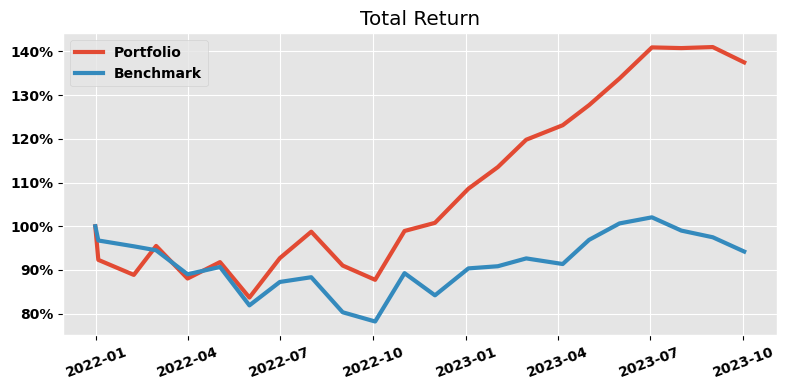

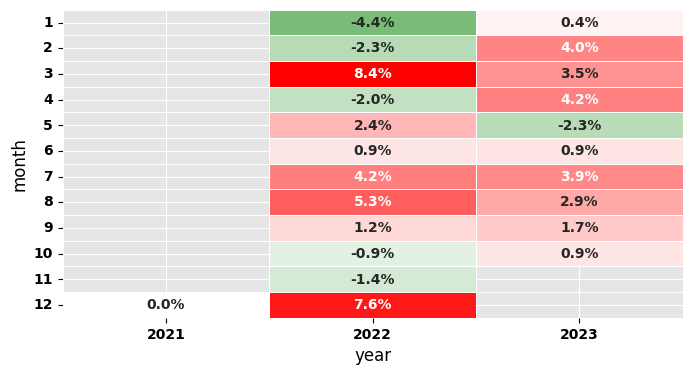

In [ ]:
# 績效指標
def perf_cal(df_tr, name_1, name_2):
    status = {}
    status['最大回撤'] = -((df_tr[name_1].cummax() - df_tr[name_1])/df_tr[name_1].cummax()).max()
    status['累積報酬'] = [df_tr[name_1].iloc[-1]]
    status['年化報酬'] = [(df_tr[name_1].iloc[-1] ** (12/len(df_tr))-1)]
    std = df_tr[name_2].std() * np.sqrt(12)
    status['Sharpe Ratio'] = status['年化報酬'] / std
    status = pd.DataFrame(status).transpose()
    status.columns = [name_1]
    return status

# 累積報酬圖
def plot_total_return(df_portfolio_tr,df_benchmark_tr, name):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_portfolio_tr.index, df_portfolio_tr['Portfolio Total Return'], label='Portfolio', linewidth=3)
    ax.plot(df_benchmark_tr.index, df_benchmark_tr['Benchmark Total Return'], label='Benchmark', linewidth=3)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    plt.legend(loc='upper left')
    plt.title('Total Return')
    plt.xticks(rotation=20)
    plt.tight_layout()

# 月度勝率圖
def plot_monthly_return(df_portfolio_tr, df_benchmark_tr):
    df_portfolio_tr['year'] = df_portfolio_tr.index.year
    df_portfolio_tr['month'] = df_portfolio_tr.index.month
    df_benchmark_tr['year'] = df_benchmark_tr.index.year
    df_benchmark_tr['month'] = df_benchmark_tr.index.month
    rt_pivot_strategy = df_portfolio_tr.pivot(index='year', columns='month', values='Portfolio Return')
    rt_pivot_benchmark = df_benchmark_tr.pivot(index='year', columns='month', values='Benchmark Return')
    rt_pivot_excess = rt_pivot_strategy - rt_pivot_benchmark

    cmap1= LinearSegmentedColormap.from_list("custom", [(0, "green"), (0.5, "white"), (1, "red")])
    fig, ax = plt.subplots(figsize=(8,4))
    sns.heatmap(rt_pivot_excess.T,annot=True, xticklabels= True, yticklabels= True, cmap=cmap1, center=0, fmt='.1%', cbar=False, linewidths=0.5)
    plt.yticks(rotation=0)


# 呼叫績效呈現函式
plot_total_return(df_portfolio_tr,df_benchmark_tr, 'Portfolio_1')
plot_monthly_return(df_portfolio_tr, df_benchmark_tr)
portfolio_perf = perf_cal(df_portfolio_tr, 'Portfolio Total Return','Portfolio Return')
benchmark_perf = perf_cal(df_benchmark_tr, 'Benchmark Total Return','Benchmark Return')
summary_perf = pd.concat([portfolio_perf,benchmark_perf],axis=1)
summary_perf